# PSD

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.interpolate as interpolate
from scipy import signal

### Physical Parameters

In [2]:
# eta * Ma ^2 = 10^-3
Ma = math.sqrt(10**(-3))
K = 1
eta = 1

### Functions of Ma

In [3]:
meandeltaT = np.pi
# variables for generating F2, H, and G1
stdF2 = eta * Ma**2
limitY2 = eta 
eqmean = 0

### Calculation parameters

In [4]:
L = 1
M = 10**4
N = 1
m = 10**2

J = 200
dTau= 2 * np.pi / J

Tr = K * meandeltaT

### Initial Conditions

In [5]:
y1 = 0
t = 0

initial_AT = 0
initial_dAdT = 0

## Functions

In [6]:
def fundeltaT(M, dTau):
    n_bins = 200
    deltaT = []
    
    # generate a rayleigh distribution from which to pick values for deltaT from
    rayleigh = np.random.rayleigh(meandeltaT, M)                           
    hist, bin_edges = np.histogram(rayleigh, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    
    for i in range(M):
        # picks a random value from the rayleigh distribution
        r = np.random.rand(1)
        deltaTtemp = inv_cdf(r)
        
        # rounds deltaTtemp up or down to be an interger multiple of dTau
        if (deltaTtemp % dTau < 0.005):
            deltaTtemp2 = deltaTtemp - (deltaTtemp % dTau)
        else:
            deltaTtemp2 = deltaTtemp + dTau - (deltaTtemp % dTau)
            
        deltaT.append(deltaTtemp2[0])
    return deltaT

In [7]:
# generating F2, G1
def funF_k(std, limit, deltaT, eqmean, y1):
    F_k =[]
    
    for i in range(len(deltaT) - 1):
        
        # Tn is halfway through the eddy
        Tn = ((deltaT[i] + deltaT[i+1]) / 2)
        
        stdevt = ((1 - math.exp(-2 * Tn / Tr)) * std ** 2) ** (1/2)
        meant = eqmean + math.exp(-Tn / Tr) * (y1 - eqmean)
        
        # y1 is chosen from markov conditional probability function
        y1 = np.random.normal(meant, stdevt, 2)[0]
        # loops through each eddy
        for j in np.linspace(0, deltaT[i], int(deltaT[i] / dTau)):
            x = j / deltaT[i]
            if j == deltaT[i]:
                pass
            else:
                F_k.append(16 * y1 * x**2 * (1 - x)**2)
        
    return F_k

## generate PSD

In [8]:
deltaT = fundeltaT(M, dTau)
F2 = funF_k(stdF2, limitY2, deltaT, eqmean, y1)

In [15]:
fs = J/(2 * np.pi)
q, PSD = signal.periodogram(F2, fs)
logPSD = np.log10(PSD)
logq = np.log10(q)

/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


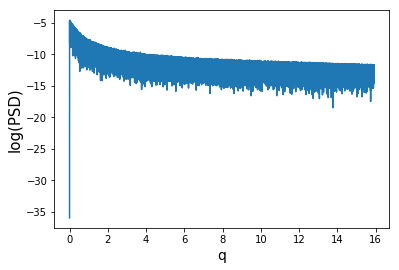

In [10]:
plt.plot(q, logPSD)
plt.xlabel('q', size= 14)
plt.ylabel('log(PSD)', size=15)
plt.show()

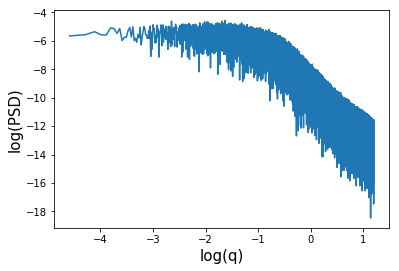

In [11]:
plt.plot(logq, logPSD)
plt.xlabel('log(q)', size=15)
plt.ylabel('log(PSD)', size=15)
plt.show()

In [19]:
qmin = (2*np.pi) / np.sum(deltaT)
print("log(q_min) = ", np.log10(qmin))
qmax = np.pi/min(deltaT)
print("log(q_max) = ", np.log10(qmax))

log(q_min) =  -3.793771183143752
log(q_max) =  1.6989700043360187


## Check with parseval's theorem

In [13]:
tot = 0
for i in range(1, len(PSD)):
    dq = q[i] - q[i-1]
    tot += PSD[i] * dq
    
avgF2 = np.sum(F2)/len(F2)
diffsqr = [(value - avgF2)**2 for value in F2]
avgdiffsqr = np.sum(diffsqr)/len(diffsqr)

print(r"\int^{\inf}_{0} P(q) dq = \langle (F2 - \langle F2 \rangle)^{2} \rangle")
print(tot, " = ", avgdiffsqr)

\int^{\inf}_{0} P(q) dq = \langle (F2 - \langle F2 \rangle)^{2} \rangle
3.974861453108637e-07  =  3.9748614531088114e-07
